# Merging Datasets

**Author:** Marang Mutloatse

**Description:** This script prepares the Patient demographics dataset for unified view creation.

**Version:** 0.0.1

**Status:** Development

In [1]:
import pandas as pd
import yaml
import datetime as dt
import warnings
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
import os
from sklearn.impute import SimpleImputer
from datetime import timedelta, date
plt.style.use('fivethirtyeight')
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

# Working Functions

In [2]:
def load_excel_sheet(path: str):
    if path is not None:
        try:
            xls = pd.ExcelFile(path)
            df = xls.parse(skiprows=0)
            return df
        except Exception as e:
            print(f"Exception on loading excel spreadsheet with error: {e}")
            
def one_hot_encode_col(df,dummies_col:str,prefix_entry:str):
    if df is not None:
        try:
            dummies = pd.get_dummies(df[dummies_col], prefix=prefix_entry,drop_first=False)
            df = df.join(dummies)
            return df
        except Exception as e:
            print(f"Exception on one hot encoding with error: {e}")

# Loading Data

In [3]:
user_dev_path = os.path.dirname(os.getcwd())
try: 
    with open (user_dev_path + '/' + 'config_LTFU.yaml', 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print(f'Error reading the config file, {e}')

In [4]:
input_root = config['rise_files']['raw_data_path']
patient_file = config['rise_files']['raw_patient_file']
patient_input = input_root + patient_file
print(patient_input)

/data/rise_data/PatientDemographicsData.xlsx


In [5]:
df = load_excel_sheet(patient_input)

## Date Time Conversion

In [6]:
# list datetime columns
DATE_COLS = [
    "DATE_BIRTH",
    "DATE_STARTED",
    "DATE_REGISTRATION",
    "DATE_CONFIRMED_HIV",
    "DATE_LAST_REFILL",
    "DATE_NEXT_REFILL",
    "DATE_CURRENT_STATUS",
    "DATE_LAST_CLINIC",
    "DATE_NEXT_CLINIC",
    "DATE_LAST_CD4",
    "DATE_LAST_VIRAL_LOAD",
    "VIRAL_LOAD_DUE_DATE",
    "DATE_ENROLLED_PMTCT"
]
# Convert to datetime format
df.loc[:,DATE_COLS] = df.loc[:,DATE_COLS].apply(pd.to_datetime,errors = "coerce")

## Data Preparation

### Age Prep

In [7]:
# Filter for Correct
conditions = [(df['age_unit'] =='month(s)'),(df['age_unit'] == 'day(s)'),(df['age_unit'] == 'year(s)')]
values = [(df['AGE']/12),(df['AGE']/365),df['AGE']]
df['EF_CURRENT_AGE'] = np.select(conditions,values)

### Date of Birth Prep

In [8]:
df["EF_CURRENT_AGE"] = df["EF_CURRENT_AGE"].astype(int)
df["EF_CURRENT_AGE"] = df["EF_CURRENT_AGE"].astype(str)
# remove erroneous digits before age
df["EF_CURRENT_AGE"] = df["EF_CURRENT_AGE"].str.replace(r'^\d(\d{2})$', r'\1')
df["EF_CURRENT_AGE"] = df["EF_CURRENT_AGE"].astype(int)

In [9]:
# Fill empty DOB with approximate values
last_updated_date = pd.to_datetime('2021-05-31')

# Filter Outliers
df = df[df['EF_CURRENT_AGE'] < 120]

# Approximate Date of Birth
df['DATE_BIRTH'] = df['DATE_BIRTH'].combine_first(
    df['EF_CURRENT_AGE'].transform(lambda x: last_updated_date - pd.DateOffset(years=x))
)

### Age and Gender Check

Text(0.5, 1.0, 'Age Distribution')

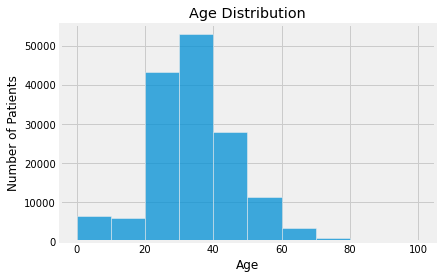

In [10]:
df_AGE =  df.query("EF_CURRENT_AGE < 100")
ax_age = sns.histplot(data=df_AGE, x="EF_CURRENT_AGE", binwidth=10)
ax_age.set(xlabel='Age', ylabel='Number of Patients')
ax_age.set_title("Age Distribution")

Text(0.5, 1.0, 'Number of Patients: By Gender')

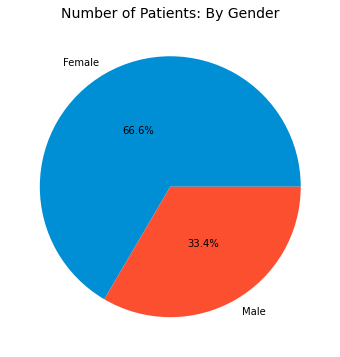

In [11]:
df_pie = df.groupby("GENDER")["PATIENT_ID"].count()
pie, ax = plt.subplots(figsize=[10,6])
labels = df_pie.keys()
plt.pie(x=df_pie, autopct="%.1f%%", labels=labels, pctdistance=0.5)
plt.title("Number of Patients: By Gender", fontsize=14)

### Data Cleaning

In [12]:
# rename state residence columns
df = df.rename(columns={'STATE':'EF_STATE_RESIDENCE'})

df.columns = df.columns.str.upper()
df = df.rename(columns={'FACILITY NAME': 'FACILITY_NAME','LGA': 'EF_LGA_RESIDENCE'})

In [13]:
standardized_col = [
    "MARITAL_STATUS",
    "OCCUPATION",
    "EDUCATION",
    "ENTRY_POINT",
    "STATUS_REGISTRATION",
    "ENROLLMENT_SETTING",
    "CURRENT_STATUS",
    "CAUSE_DEATH",
    "WARD",
    "TB_STATUS",
    "EF_STATE_RESIDENCE",
    "EF_LGA_RESIDENCE",
]

In [14]:
# Grouping entries by first lowering, then capitalizng all word
for col in standardized_col:
    df[col] = df[col].str.title()

In [15]:
education_dict = {
    "None": "None",
    "Junior Secondary": "Junior Secondary",
    "Senior Secondary": "Senior Secondary",
    "Post Secondary": "Post Secondary",
    "Quranic":"Quranic",
    "Quranic Education": "Quranic",
    "Quranic Education,Quranic Education": "Quranic",
    "Senior Secondary,Senior Secondary": "Senior Secondary",
    "Post Secondary,Post Secondary": "Post Secondary",
}

marital_status_dict = {
    "Married": "Married",
    "Single": "Single",
    "Widowed": "Widowed",
    "Divorced": "Divorced",
    "Separated": "Separated",
    "Seperated": "Separated",
    "Windowed": "Widowed",
}

enrollment_setting_dict = {
    "Facility":"Facility",
    "Community":"Community",
    "Community Based Organisation": "Community",
    "Clinical Platforms (Community Pharmacy)":"Community",
    "Clinical Platforms (Chemists/Pmvs/Dispensary)":"Clinical Platforms",
    "Clinical Platforms (Phcs/Private Clinics/Nursing Homes)":"Clinical Platforms",
    "Clinical Platforms (Laboratories)":"Clinical Platforms",
    "Clinical Platforms (Tbas)":"Clinical Platforms",
}

last_clinic_stage_dict = {
    "Stage I":"Stage I",
    "Stage II":"Stage II",
    "Stage III":"Stage III",
    "Stage II?":"Stage II",
    "Stage IIt":"Stage III",
    "Stage IV": "Stage IV",   
}

status_registration_dict = {
    "Hiv+ Non Art":"Hiv+ Non Art",
    "Art Transfer In":"Art Transfer In",
    "Pre-Art Transfer In":"Pre-Art Transfer In",
    "Hiv Exposed Status Unknown":"Hiv Exposed Status Unknown",
    "Hiv Exposed Infant Status Unknown":"Hiv Exposed Status Unknown",
    "Art Start - External":"Art Start - External",
    "Hiv Negative":"Hiv Negative",
    "Hiv Exposed Infant Status Negative":"Hiv Negative",
}

entry_point_dict = {
    "Hct":"Hct",
    "Outreach":"Outreach",
    "Outreaches":"Outreach",
    "In-Patient":"In Patient",
    "In Patients":"In Patient",
    "Opd":"Opd",
    "Pmtct":"Pmtct",
    "Anc/Pmtct":"Pmtct",
    "Cbo":"Cbo",
    "Others":"Others",
    "Transfer-In":"Transfer-In",
    "Tb Dots":"Others",
    "Sti Clinic":"Others",
}
# tb_status_dict = {"No Sign Or Symptoms Of Tb":"No Sign Or Symptoms Of Tb",
#                  "No Signs Or Symptoms Of Tb":"No Sign Or Symptoms Of Tb",
#                  "Currently On Inh Prophylaxis":"Currently On Inh Prophylaxis",
#                  "Currently On Inh Prophylaxis,Currently On Inh Prophylaxis": "Currently On Inh Prophylaxis",
#                  }

In [16]:
# MAPPING CLEANED CATEGORICAL Variables
df['EDUCATION'] = df['EDUCATION'].map(education_dict)
df['MARITAL_STATUS'] = df['MARITAL_STATUS'].map(marital_status_dict)
df['ENROLLMENT_SETTING'] = df['ENROLLMENT_SETTING'].map(enrollment_setting_dict)
df['LAST_CLINIC_STAGE'] = df['LAST_CLINIC_STAGE'].map(last_clinic_stage_dict)
df['STATUS_REGISTRATION'] = df['STATUS_REGISTRATION'].map(status_registration_dict)
df['ENTRY_POINT'] = df['ENTRY_POINT'].map(entry_point_dict)

### Dealing with Missing Values

In [17]:
# Imputing mode for columns
imputer = SimpleImputer(missing_values=np.NaN,strategy='most_frequent')

df["EF_STATE_RESIDENCE"] = df.groupby(["STATE", "L.G.A", "FACILITY_NAME"], sort=False)[
    "EF_STATE_RESIDENCE"
].apply(lambda x: x.fillna(x.mode().iloc[0]))

df["EF_LGA_RESIDENCE"] = df.groupby(["STATE", "L.G.A", "FACILITY_NAME"], sort=False)[
    "EF_LGA_RESIDENCE"
].apply(lambda x: x.fillna(x.mode().iloc[0]))

df["ENROLLMENT_SETTING"] = df.groupby(
    ["STATE","L.G.A","FACILITY_NAME"], sort=False)["ENROLLMENT_SETTING"].apply(lambda x: x.fillna(x.mode().iloc[0]))

df["ENROLLED_OVC"] = df["ENROLLED_OVC"].fillna(0.0)
df["BIOMETRIC"] = df["BIOMETRIC"].fillna(0.0)
df["STATUS_REGISTRATION"] = pd.DataFrame(
    imputer.fit_transform(df[["STATUS_REGISTRATION"]]))
df["CURRENT_STATUS"] = pd.DataFrame(imputer.fit_transform(df[["CURRENT_STATUS"]]))
df["LAST_CLINIC_STAGE"] = df.groupby(["CURRENT_STATUS"], sort=False)[
    "LAST_CLINIC_STAGE"
].apply(lambda x: x.fillna(x.mode().iloc[0]))

df["MARITAL_STATUS"] = df["MARITAL_STATUS"].fillna("Unknown")
df["OCCUPATION"] = df["OCCUPATION"].fillna("Unknown")
df["EDUCATION"] = df["EDUCATION"].fillna("Unknown")
df["ENTRY_POINT"] = df["ENTRY_POINT"].fillna("Unspecified")
df["RECENCY_TESTING"] = df["RECENCY_TESTING"].fillna("Unspecified")

## Categorical Encoding

### Label Encoding

In [18]:
education_dict_label = {
    "None": 0,
    "Unknown":0,
    "Junior Secondary": 1,
    "Senior Secondary": 2,
    "Post Secondary": 3,
    "Quranic":2,
}

last_clinic_stage_dict_label = {
    "Stage I":0,
    "Stage II":1,
    "Stage III":2,
    "Stage IV":3,   
}

occupation_dict_label = {
    "Unemployed":0,
    "Unknown":0,
    "Student":1,
    "Employed":2,
    "Retired":3,
}

gender_dict_label = {
    "Male":1,
    "Female":0,
}

recency_test_label = {
    "Unspecified":0,
    "No Documented Test Result":0,
    "Long Term Infection":2,
    "Recent Infection":1,
}

In [19]:
# Mapping of encoding
df['EDUCATION'] = df['EDUCATION'].map(education_dict_label)
df['LAST_CLINIC_STAGE'] = df['LAST_CLINIC_STAGE'].map(last_clinic_stage_dict_label)
df['OCCUPATION'] = df['OCCUPATION'].map(occupation_dict_label)
df['EF_IS_MALE'] = df['GENDER'].map(gender_dict_label)
df['RECENCY_TESTING'] = df['RECENCY_TESTING'].map(recency_test_label)

In [20]:
# Otherise columns with high cardinality
# lga_list = df['L.G.A'].to_list()
# state_list = df['STATE'].to_list()

state_vals = df['EF_STATE_RESIDENCE'].value_counts(normalize=True).head(4).index.tolist()
df.loc[~df["EF_STATE_RESIDENCE"].isin(state_vals), "EF_STATE_RESIDENCE"] = "Other"

# Otherise based on value in LGA and State
# df.loc[~df["L.G.A"].isin(set(lga_list)), "EF_LGA_RESIDENCE"] = "Other"
# df.loc[~df["STATE"].isin(set(state_list)), "EF_STATE_RESIDENCE"] = "Other"

### One Hot Encoding

In [21]:
# df = one_hot_encode_col(df,'STATE','EF_STATE')
# df = one_hot_encode_col(df,'L.G.A','EF_LGA')
df = one_hot_encode_col(df,'ENROLLMENT_SETTING','EF_ENROLLMENT_SETTING')
df = one_hot_encode_col(df,'STATUS_REGISTRATION','EF_STATUS_REGISTRATION')
df = one_hot_encode_col(df,'MARITAL_STATUS','EF_MARITAL_STATUS')
df = one_hot_encode_col(df,'ENTRY_POINT','EF_ENTRY_POINT')
df = one_hot_encode_col(df,'EF_STATE_RESIDENCE','EF_STATE_RESIDENCE')
#df = one_hot_encode_col(df,'EF_LGA_RESIDENCE','EF_LGA_RESIDENCE')
# df = one_hot_encode_col(df,'Regimen','EF_REGIMEN')
# df = one_hot_encode_col(df,'Regimen Line','EF_REGIMEN_LINE')
# #df = one_hot_encode_col(df,'Facility Name','EF_FACILITY_NAME')

# Export Information

In [22]:
# Replace spaces in columns names
df.columns = df.columns.str.replace(' ','_')

# Standardizing columns
df.columns = map(lambda x: str(x).upper(), df.columns)

In [23]:
drop_cols = [
    "PARTNERINFORMATION_ID",
    "SOURCE_REFERRAL",
    "TIME_HIV_DIAGNOSIS",
    "AGREED_DATE",
    "CAUSE_DEATH",
    "AGE_UNIT",
    "AGE",
    "GENDER",
    "DATE_ENROLLED_PMTCT",
    "RECENCY_CONSENT",
    "DATE_LAST_VIRAL_LOAD",
    "VIRAL_LOAD_TYPE",
    "DATE_LAST_CD4",
    "DATE_TRACKED",
    "WARD",
    "LAST_REFILL_SETTING",
    "UNIQUE_ID",
    "HOSPITAL_NUM",
    "OUTCOME",
    "VIRAL_LOAD_DUE_DATE",
    "FACILITY_NAME",
    "STATE",
    "L.G.A",
    "TB_STATUS",
    "STATUS_REGISTRATION",
    "MARITAL_STATUS",
    "ENROLLMENT_SETTING",
    "ENTRY_POINT",
    "EF_STATE_RESIDENCE",
]
df.drop(columns=drop_cols, inplace=True)

In [24]:
df = df.add_prefix('P_')

In [30]:
df.to_csv(input_root+'feature_patient.csv',index=False,header=True)